$\newcommand{\v}[1]{\mathbf{#1}}$

# Introduction
We want to maximize the log-likehood of data $\log p_{\theta}(x)$ **indirectly** by maximizing its lowwer bound ELBO instead. 

Recall that 
$$\begin{align}ELBO &= E_{q_{\phi}(z)}\big[\log p_{\theta}(x,z) - \log(q_{\phi}(z) \big]\\
&= E_{q_{\phi}(z)}\log p_{\theta}(x|z)p(z) - \log(q_{\phi}(z) \big]\\
&= E_{q_{\phi}(z)}\log p_{\theta}(x|z) + \log_{\theta}p(z) - \log(q_{\phi}(z) \big]
\end{align}$$

To optimize ELBO we need to be able to compute its gradient wrt to parameters $\phi, \theta$. If both model and guide are from exponential family then we can derive this gradient in a closed form. Hence the standard gradient descent can be applied easily. 

Unfortunately, for a general model and guide, it is not possible to derive a closed form for the gradient. To overcome this, we use Monte Carlo to compute unbiased estimate of the ELBO(q) gradients.

$$\nabla_{\phi, \theta}ELBO = \nabla_{\phi, \theta} E_{q_{\phi}(z)}\big[\log p_{\theta}(x,z) - \log(q_{\phi}(z) \big]$$

There are two main questions to ask here:
1. How to fastly compute the log likelihood term $\log p_{\theta}(x|z)$ since our dataset could contains millions of data points.
2. We now use $\theta$ to denote $\theta, \phi$ collectively and ask ourself a more generic quesiton: how do we estimate $\nabla_\phi E_{q_\phi(z)}\big[f_{\phi}(z) \big]?$

# Fast Log-likelhood evaluation

By exploiting the conditional indenpence of data points, we can estimate this term as:

$$\sum_{i=1}^{N}\log p(x_i | z) \approx \frac{N}{M}\sum_{i \in I_M}\log p(x_i|z),$$

where $I_M$ is mini-batch indices of dataset.

To indicate conditional independence specifically, we can use ``pyro.plate``: 

```python
def model(data):
    # sample f from the beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data [WE ONLY CHANGE THE NEXT LINE]
    for i in pyro.plate("data_loop", len(data)):
        # observe datapoint i using the bernoulli likelihood
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

```

Or we can do it in vectorized fashion:

```python
with plate('observe_data'):
    pyro.sample('obs', dist.Bernoulli(f), obs=data)
```

and then we have the subsampling for free

```python
with plate('observe_data', size=10, subsample_size=5) as ind:
    pyro.sample('obs', dist.Bernoulli(f),
                obs=data.index_select(0, ind))
```

More details can be found [here](http://pyro.ai/examples/svi_part_ii.html)

# ELBO Gradient Estimators

Ok so we want to maximize the log-likehood of data $\log p_{\theta}(\v{x})$ **indirectly** by maximizing its lowwer bound ELBO instead. 

Recall that $ELBO = E_{q_{\phi}(\v{z})}\big[\log p_{\theta}(\v{x},\v{z}) - \log(q_{\phi}(\v{z}) \big]$

To optimize ELBO we need to be able to compute its gradient wrt to parameters $\phi, \theta$. If both model and guide are from exponential family then we can derive this gradient in a closed form. Hence the standard gradient descend optimization can be applied easily. 

Unfortunately, for a general model and guide, it is not possible to derive a closed form for the gradient. The simplest one is the sigmoid function. (write sth here more). 

To overcome the aforementioned problem, we use Monte Carlo to compute unbiased estimate of 

$$\nabla_{\phi, \theta}ELBO = \nabla_{\phi, \theta} E_{q_{\phi}(\v{z})}\big[\log p_{\theta}(\v{x},\v{z}) - \log(q_{\phi}(\v{z})\big]$$

To explain how to do this we ask ourself a more general question? How to estimate $$\nabla_\phi E_{q_\phi(z)}\big[f_{\phi}(z) \big]$$

# Estimation of $\nabla_\phi E_{q_\phi(z)}\big[f_{\phi}(z) \big]$

### Reparameterizable random variables



$$\nabla_\phi E_{q_\phi(z)}\big[f_{\phi}(z) \big] = E_{q(\epsilon)}[f_{\phi}(g_{\phi(\epsilon)})]$$

The key idea is to move all the depdence on $\phi$ into the expection. Note that $q(\epsilon)$ is a fixed distribution. 

Because of  [Leibniz integral rule](https://en.wikipedia.org/wiki/Leibniz_integral_rule), we can move the gradient straight into the expectation to have:

$$\nabla_\phi E_{q(\epsilon)}[f_{\phi}(g_{\phi(\epsilon)})] = E_{q(\epsilon)}\big[\nabla_{\phi} f_{\phi}(g_{\phi}(\epsilon)\big].$$


The condition here is f() and g() is sufficiently smooth function. This means they are at least continuous. **So reparameterization trick does not work with discrete distribution!**. 

This is what was used in Variational Auto-Encoder paper.

**Add some code here**


### Non-reparameterizable random variables

For some cases reparameterization is not possible. For example, all discrete distributions.

By some mathematical manipulations (see Black box variational inference paper or the tutorial from Blei, and Pyro documentation), we can rewrite the gradient of interest as 

$$E_{q_{\phi}(\v{z})} \big[ \big( \nabla_\phi \log q_\phi(\v{z})\big) f_\phi(\v{z}) + \nabla_{\phi}f_\phi(\v{z})\big]$$

This is known as REINFORCE estimator, score function, or likeliehood ratio estimator. It is easy to estimate REINFORCE estimator using Monte Carlo methods. **Perhaps this is where Pyro discrete variable parallized enumeration ELBO comes in?**


### Variance Reduction
When estimate gradient of ELBO in general we need to apply some variance reduction technique. There are basic two main approaches.

1. Rao-Blackwellization: We remove terms whose expectation are zeroes but contribute to larger variance  For each non-parameterizable $z$, we have a loss term $\big(\nabla_{\phi} \log q_{\phi}(z) \big)f_{\phi}(z)$. We can remove some of the terms in $f_{\phi}(z)$ that are not downstream of $z$. This requires dependency tracking in a given model. Typically if $z_2$ is declared after $z_2$ then it is considered to be dependent on $z_1$.

2. Control variates: Instead of removing terms like in the first approach above, we add more terms.

# References

1. [Pyro](http://pyro.ai/examples/svi_part_i.html#)
2. [Gradient Estimation Using Stochastic Computation Graphs](https://arxiv.org/abs/1506.05254)

In [31]:
import pyro
import torch
import seaborn as sns

In [29]:
from pyro.distributions import Categorical, Bernoulli, Beta

In [30]:
beta_dist = Beta(2., 3.)

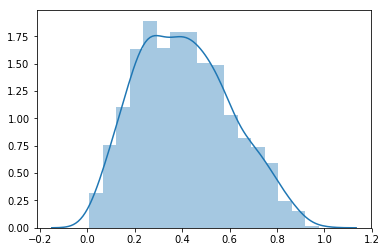

In [34]:
sns.distplot(beta_dist.sample((1000,)))

In [1]:
s=1

In [6]:
import pyro.distributions as dist
import pyro
import torch

In [7]:
hs = pyro.sample(f'H_{s}', dist.Bernoulli(pyro.param(name='theta_s', init_tensor=torch.tensor(0.5))))

In [8]:
hs

tensor(1.)

In [11]:
params = pyro.get_param_store()

In [13]:
params['theta_s']

tensor(0.5000, requires_grad=True)

In [15]:
dom_size = 10

In [21]:
init_tensor = 1/dom_size * torch.ones(size=(10,))

In [23]:
m = 1

In [24]:
dist.Categorical(probs=pyro.param(name=f'theta_{m}', init_tensor=init_tensor ))

Categorical(probs: torch.Size([10]))

In [25]:
params['theta_1']

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000], requires_grad=True)

In [ ]:
torch.constr

In [26]:
import numpy as np

In [28]:
mask = np.ones((3,3))

In [30]:
mask[0,2]

1.0

In [32]:
s = 1
c=3

In [33]:
f'b_{s,c}'

'b_(1, 3)'

In [34]:
dist.Dirichlet?

Init signature: dist.Dirichlet(concentration, validate_args=None)
Docstring:     
Wraps :class:`torch.distributions.dirichlet.Dirichlet` with
:class:`~pyro.distributions.torch_distribution.TorchDistributionMixin`.
File:           ~/miniconda3/envs/sdk/lib/python3.6/site-packages/pyro/distributions/torch.py
Type:           ABCMeta
Subclasses:     


In [36]:
pyro.sample?

Signature: pyro.sample(name, fn, *args, **kwargs)
Docstring:
Calls the stochastic function `fn` with additional side-effects depending
on `name` and the enclosing context (e.g. an inference algorithm).
See `Intro I <http://pyro.ai/examples/intro_part_i.html>`_ and
`Intro II <http://pyro.ai/examples/intro_part_ii.html>`_ for a discussion.

:param name: name of sample
:param fn: distribution class or function
:param obs: observed datum (optional; should only be used in context of
    inference) optionally specified in kwargs
:param dict infer: Optional dictionary of inference parameters specified
    in kwargs. See inference documentation for details.
:returns: sample
File:      ~/miniconda3/envs/sdk/lib/python3.6/site-packages/pyro/primitives.py
Type:      function


In [43]:
b_sc = pyro.sample(name='b_sc', dist.Dirichlet(concentration=torch.tensor([0.3, 0.3, 0.3])))

SyntaxError: positional argument follows keyword argument (<ipython-input-43-c6dc7a4d91c6>, line 1)

In [41]:
b_sc

tensor([0.3571, 0.0822, 0.5607])

In [42]:
b_sc.sum()

tensor(1.)

In [44]:
dist.Dirichlet?

Init signature: dist.Dirichlet(concentration, validate_args=None)
Docstring:     
Wraps :class:`torch.distributions.dirichlet.Dirichlet` with
:class:`~pyro.distributions.torch_distribution.TorchDistributionMixin`.
File:           ~/miniconda3/envs/sdk/lib/python3.6/site-packages/pyro/distributions/torch.py
Type:           ABCMeta
Subclasses:     
